In [2]:
from kafka import KafkaConsumer
from kafka import KafkaProducer
from kafka.errors import KafkaError
import json
from utils import lstm_encdec, orchestrate_data
import csv
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import os
import pandas as pd
import pickle
from sklearn.metrics import roc_curve
from report_generation import generate_results

In [3]:
host_1 = 'kafkaApplication_server1'
host_2 = 'kafkaApplication_server2'
rubis = 'RUBisApp'
also_rubis = 'responsetimeRubisApp'
ip = "152.46.18.175"
port = 9092
path = "normal_data/"
bootstrap_servers = ip + ":" + str(port)

## Pre-training

In [4]:
def get_df(file):
    path = ""
    df = pd.read_csv(path + file, sep=',', header=None)
    df = df.drop([0, 2], axis=1)
    df = df.dropna()
    return df

In [11]:
def train_base(window_size, input_dim, hidden_dim, epochs=7):
    models = defaultdict(lambda : defaultdict(dict))
    path = "normal_data/"
    output = "models/deploy_class/"
    hosts = ["vm16-137.vcl.ncsu.edu", "vm17-187.vcl.ncsu.edu", "vclv98-84.hpc.ncsu.edu"]
    modes = ["active", "used"]
    plugin = ["cpu", "memory"]
    
    for item in hosts:
        for i in range(2):
            models[item][modes[i]][plugin[i]] = lstm_encdec(window_size, input_dim, hidden_dim)
    
    df = get_df(path + 'vm16-137.vcl.ncsu.edu_active_cpulatest_latest.txt') 
    xtrain, xvalid, xtest = orchestrate_data(df.values, window_size, 0.9, 0.1, 0)
    models["vm16-137.vcl.ncsu.edu"]["active"]["cpu"].train_model(xtrain, xvalid, epochs)
    
    df = get_df(path + 'vm16-137.vcl.ncsu.edu_used_memorylatest_latest.txt')
    xtrain, xvalid, xtest = orchestrate_data(df.values, window_size, 0.9, 0.1, 0)
    models["vm16-137.vcl.ncsu.edu"]["used"]["memory"].train_model(xtrain, xvalid, epochs)

    df = get_df(path + 'vm17-187.vcl.ncsu.edu_active_cpulatest_latest.txt')
    xtrain, xvalid, xtest = orchestrate_data(df.values, window_size, 0.9, 0.1, 0)
    models["vm17-187.vcl.ncsu.edu"]["active"]["cpu"].train_model(xtrain, xvalid, epochs)

    df = get_df(path + 'vm17-187.vcl.ncsu.edu_used_memorylatest_latest.txt')
    xtrain, xvalid, xtest = orchestrate_data(df.values, window_size, 0.9, 0.1, 0)
    models["vm17-187.vcl.ncsu.edu"]["used"]["memory"].train_model(xtrain, xvalid, epochs)

    df = get_df(path + 'vclv98-84.hpc.ncsu.edu_active_cpulatest_latest.txt')
    xtrain, xvalid, xtest = orchestrate_data(df.values, window_size, 0.9, 0.1, 0)
    models["vclv98-84.hpc.ncsu.edu"]["active"]["cpu"].train_model(xtrain, xvalid, epochs)

    df = get_df(path + 'vclv98-84.hpc.ncsu.edu_used_memorylatest_latest.txt')
    xtrain, xvalid, xtest = orchestrate_data(df.values, window_size, 0.9, 0.1, 0)
    models["vclv98-84.hpc.ncsu.edu"]["used"]["memory"].train_model(xtrain, xvalid, epochs)

    
    for x in models.keys():
        for y in models[x].keys():
            for z in models[x][y].keys():
                with open(output + x + "_" + y + "_" + z + '.pkl', 'wb') as f:
                    pickle.dump(models[x][y][z], f, pickle.HIGHEST_PROTOCOL)
                    models[x][y][z].model.save_weights(output + x + " " + y + " " + z + ".h5")
    return models

In [20]:
def load_base():
    models = defaultdict(lambda : defaultdict(dict))
    output = "models/deploy_class/"
    hosts = ["vm16-137.vcl.ncsu.edu", "vm17-187.vcl.ncsu.edu", "vclv98-84.hpc.ncsu.edu"]
    modes = ["active", "used"]
    plugin = ["cpu", "memory"]
    
    vals = os.listdir(output)
    for item in hosts:
        for i in range(2):
            with open(output + item + "_" + modes[i] + "_" + plugin[i]  + '.pkl', 'rb') as f:
                a = pickle.load(f)
                a.model.load_weights(output + item + " " + modes[i] + " " + plugin[i] + ".h5")
                models[item][modes[i]][plugin[i]] = a
    return models

## Deploy

In [13]:
def deploy(models):
    mwindow = {}
    for x in models.keys():
        mwindow[x] = {}
        mwindow[x]["cpu"] = []
        mwindow[x]["memory"] = []
    
    online_epochs = 5
    while True:
        try:
            consumer = KafkaConsumer(auto_offset_reset='latest',
                                        bootstrap_servers=[bootstrap_servers])
            consumer.subscribe([host_1, host_2, rubis])
            while True:
                for msg in consumer:
                    response = json.loads(msg.value.decode('utf-8'))[0]
                    host = response["host"]
                    plugin = response["plugin"]
                    item = response["values"][0]
                    type_instance = response["type_instance"]
                    if type_instance != "used":
                        if type_instance != "active":
                            continue
                    try:
                        instance = models[host][type_instance][plugin]
                    except KeyError:
                        print("models keyError!")
                        
                    print("<%s:%s>" % (host, plugin), end='\t')    

                    if len(mwindow[host][plugin]) < 5:
                        mwindow[host][plugin].append(item)

                        if len(mwindow[host][plugin]) == 5:
                            #instance.micro_update(mwindow[host][plugin], online_epochs)
                            print("%s:%s" % (item, instance.is_anomalous(mwindow[host][plugin])))
                        continue
                    
                    else:
                        mwindow[host][plugin].pop(0)
                        mwindow[host][plugin].append(item)
                        #instance.micro_update(mwindow[host][plugin], online_epochs)
                        y = np.reshape(np.array(mwindow[host][plugin]), (1, instance.window_size, instance.input_dim))
                        pred = instance.predict(y)
                        max_mae = np.squeeze(np.max(np.square(y[:,:,:] - pred[:,:,:]), axis=1))
                        print(instance.is_anomalous(mwindow[host][plugin]), item)
                        print(instance.threshold, max_mae)
                        continue
                
        except Exception as e:
            print("Connection Error %s", (e))

In [14]:
def experiment_1(model, file, name):
    winwin = model.window_size
    path = "experiments/"
    outcomes = []
    vals = []
    df = get_df(file)
    window = []
    predx = []
    for index, row in df.iterrows():
        
        item = row.values[0]
    
        if(len(window) < winwin):
            window.append(item)
            if(len(window) == winwin):
                    outcomes.append(model.is_anomalous(window))
                    vals.append(item)
                    predyy = model.predict(window)
                    predx.append(float(predyy[:, (winwin-1):,:]))
            continue
        
        window.pop(0)
        window.append(item)
        outcomes.append(model.is_anomalous(window))
        vals.append(item)
        predyy = model.predict(window)
        predx.append(float(predyy[:, (winwin-1):,:]))
    
    with open(path + name + "_1.out", "a") as f:
        for i in range(len(outcomes)):
            f.write(str(vals[i]) + "," + str(outcomes[i]) + "," + str(predx[i]) + "\n")
    return

In [15]:
def experiment_2(model, file, name):
    winwin = model.window_size
    path = "experiments/"
    mains = path + "outcomes.txt"
    online_epochs = 3
    outcomes = []
    df = get_df(file)
    window = []
    vals = []
    predx = []
    for index, row in df.iterrows():
        
        item = row.values[0]
    
        if(len(window) < winwin):
            window.append(item)
            if(len(window) == winwin):
                    outcomes.append(model.is_anomalous(window))
                    model.micro_update(window, online_epochs)
                    vals.append(item)
                    predyy = model.predict(window)
                    predx.append(float(predyy[:, (winwin-1):,:]))
    
            continue
        
        window.pop(0)
        window.append(item)
        
        outcomes.append(model.is_anomalous(window))
        
        model.micro_update(window, online_epochs)
        
        predyy = model.predict(window)
        predx.append(float(predyy[:, (winwin-1):,:]))
        
        vals.append(item)

    with open(path + name + "_2.out", "a") as f:
        for i in range(len(outcomes)):
            f.write(str(vals[i]) + "," + str(outcomes[i]) + "," + str(predx[i]) + "\n")
            
    with open(mains, "a") as f:
        try:
            f.write(name + str(model.update_time / model.update_count) + "\n")
        except:
            return
    return

In [10]:
def evaluate():
    input_dim = 1
    hidden_dim = 12
    epochs = 5
    online_epochs = 3
    win_sizes = [2, 5, 7, 10, 12 , 15, 20]
    x = os.listdir(path)
    output="saved_class/"
    hosts = ["vm16-137.vcl.ncsu.edu", "vm17-187.vcl.ncsu.edu", "vclv98-84.hpc.ncsu.edu"]
    
    hosta = "vm16-137.vcl.ncsu.edu"
    filecpu = "vm16-137.vcl.ncsu.edu_active_cpulatest_latest.txt"
    filemem = "vm16-137.vcl.ncsu.edu_used_memorylatest_latest.txt"
    pathx = "normal_data/"
    
    pathy = "anomalous_data/"
    anocpu = "vm16-137.vcl.ncsu.edu_active_cpu.txt"
    anomem = "vm16-137.vcl.ncsu.edu_used_memory.txt"
    
    df_cpu = get_df(pathx + filecpu)
    df_mem = get_df(pathx + filemem)
    
    for i in win_sizes:
        
        p = lstm_encdec(i, input_dim, hidden_dim)
        xtrain, xvalid, xtest = orchestrate_data(df_cpu.values, i, 0.9, 0.1, 0)
        p.train_model(xtrain, xvalid, epochs)
        
        try:
            with open(output + str(i) + "_" + hosta + "_" + "cpu" + '.pkl', 'wb') as f:
                pickle.dump(p, f, pickle.HIGHEST_PROTOCOL)
            p.model.save_weights(output + str(i) + "_" + hosta + "_" + "cpu" + ".h5")

        except Exception as e:
            print(e)

        experiment_2(p, pathy + anocpu, filecpu + "_" + str(i))
        
        
        p = lstm_encdec(i, input_dim, hidden_dim)
        xtrain, xvalid, xtest = orchestrate_data(df_mem.values, i, 0.9, 0.1, 0)
        p.train_model(xtrain, xvalid, epochs)
        
        try:
            with open(output + str(i) + "_" + hosta + "_" + "mem" + '.pkl', 'wb') as f:
                pickle.dump(p, f, pickle.HIGHEST_PROTOCOL)
            p.model.save_weights(output + str(i) + "_" + hosta + "_" + "mem" + ".h5")

        except Exception as e:
            print(e)

        experiment_2(p, pathy + anomem, filemem + "_" + str(i))


## Main

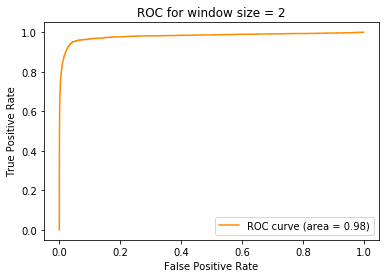

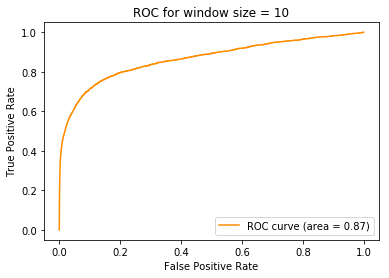

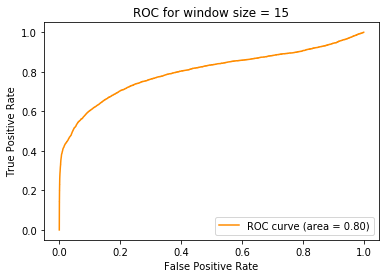

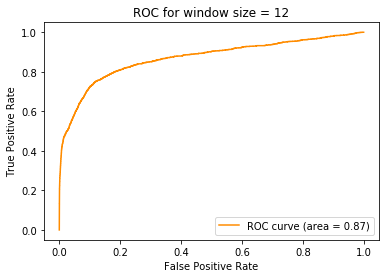

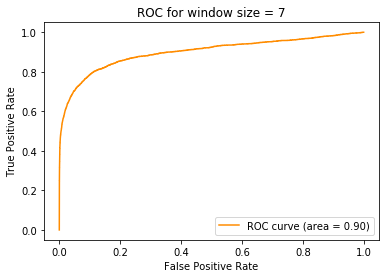

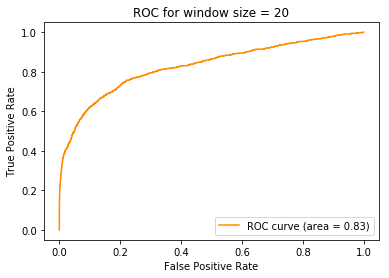

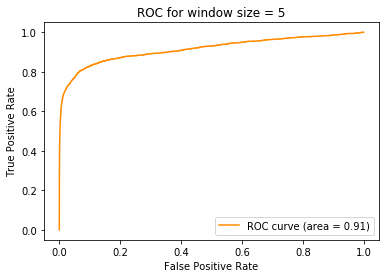

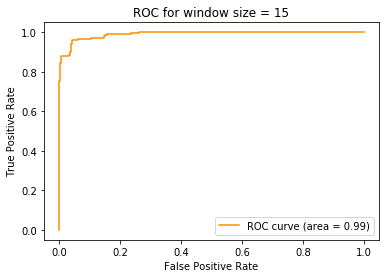

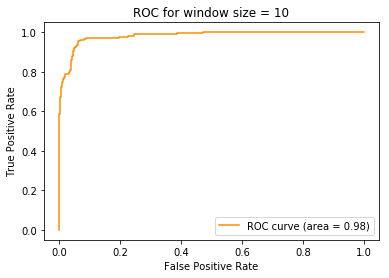

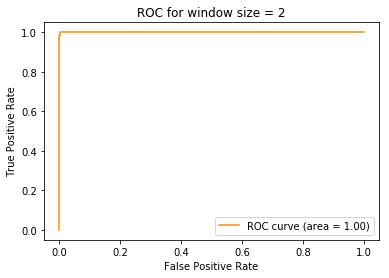

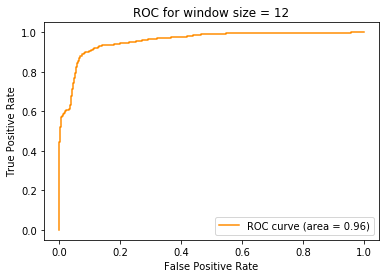

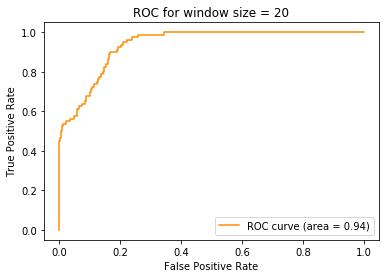

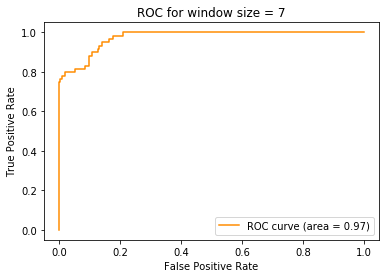

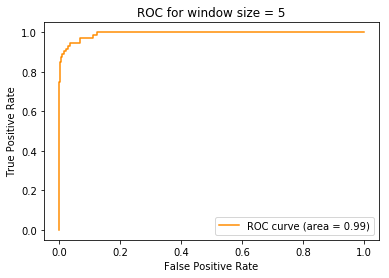

In [25]:
if __name__ == "__main__":
    window_size = 5
    input_dim = 1
    hidden_dim = 12
    epochs = 5
    ks = []
    online_epochs = 5
    trained = "models/deploy_class/"
    files = os.listdir(trained)
    #if len(files) == 0:
    #    models = train_base(window_size, input_dim, hidden_dim, epochs)
    #else:
    #    lmodels = load_base()
    #deploy(lmodels)
    
    exp = "experiments/"
    files = os.listdir(exp)
    if len(files) == 0:
        evaluate()
    else:
        generate_results()